In [3]:
from lim import lim
import source.tools._utils as ut
import source.tools._vid_tools as vut

import numpy as np
from numpy.linalg import inv

import astropy.units as u

from scipy.interpolate import interp1d as i1d
from scipy.integrate import quad

import pickle
import finufft

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

color = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Tools \& Functions

In [21]:
def merge_dicts(D):
    '''
    Merges dictionaries
    '''
    dic = {}
    for k in D:
        dic.update(k)
    return dic

def save_obj(obj, name ):
    '''
    Saves the object (generally a list) using pickle
    '''
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def save_in_file(name, lis):
    '''
    Save the list (i.e. [k, Pk, sk]) in a file with path 'name'
    Arguments: name = <path>, lis = <what to save>
    '''
    LEN = len(lis[0])
    lenlis = len(lis)
    for i in range(1, lenlis):
        if len(lis[i]) != LEN:
            raise Exception('ALL items in the list to save MUST be 1d arrays with the same length!')
    
    MAT = np.zeros((LEN,lenlis))
    header = 'Units::   '
    for i in range(0,lenlis):
        MAT[:,i] = lis[i].value
        header += str(lis[i].unit)+'\t || '

    np.savetxt(name,MAT,header=header)
    return

def plot_2d(covmat,index,center,ax,color,TwoSigma=True,filled=True,factors=None,alpha=1,zorder=1):
    '''
    Paints 2d ellipses representing forecast constraints from the Fisher matrix. 
    Uses https://arxiv.org/pdf/0906.4123.pdf
    '''
    
    #define colors:
    red2 = 'lightcoral' # 2sigma
    red1 = 'red' # 1sigma
    
    blue2 = '#a6cee3' # 2sigma
    blue1 = '#1f78b4' # 1sigma
    
    # green2 = '#b2df8a' # 2sigma
    # green1 = 'green' # 1sigma
    green2 = 'darkseagreen' # 2sigma
    green1 = 'forestgreen' # 1sigma
    
    black1 = '#232323' # 1sigma
    black2 = '#A9A9A9' # 2sigma
    
    purple1 = 'mediumpurple'
    purple2 = 'plum'
    
    yellow1 = 'gold'
    yellow2 = 'lemonchiffon'
    
    grey1 = 'slategrey'
    grey2 = 'beige'

    orange1 = 'darkorange'
    orange2 = 'moccasin'

    maroon1 = 'maroon'
    maroon2 = 'lightsalmon'

    myblue1 = 'dodgerblue'
    myblue2 = 'lightskyblue'

    if color == 'red':
        clr = [red1,red2]
    elif color == 'blue':
        clr = [blue1,blue2]
    elif color == 'forestgreen':
        clr = [green1,green2]
    elif color == 'black':
        clr = [black1,black2]
    elif    color == 'purple':
        clr = [purple1,purple2]
    elif    color == 'yellow':
        clr = [yellow1,yellow2]
    elif    color == 'maroon':
        clr = [maroon1,maroon2]
    elif color == 'grey':
        clr = [grey1,grey2]
    elif color == 'orange':
        clr = [orange1,orange2]
    elif color == 'darkorange':
        clr = [orange1,orange2]
    elif color == 'dodgerblue':
        clr = [myblue1,myblue2]
    else:
        clr = [color,color]
    
    #Define the 2x2 covariance matrix from the covariance matrix obtained from the inverse of the Fisher
    matrix = covmat[np.ix_(index,index)]
    
    #Rescale the errors if needed
    if factors: 
        s1 = matrix[0,0]**0.5*factors[0]
        s2 = matrix[1,1]**0.5*factors[1]
        s12 = matrix[0,1]*factors[0]*factors[1]
        center[0] *= factors[0]
        center[1] *= factors[1]
    else:
        s1 = matrix[0,0]**0.5
        s2 = matrix[1,1]**0.5
        s12 = matrix[0,1]
        
    rho = s12/s1/s2
    # print ('correlation =', rho)
    #1sigma and 2sigma Delta chi2
    Deltachi2 = 2.3
    TwoSigmaDeltachi2 = 6.17
    
    # xpar = np.linspace(-4*s1,4*s1,128)
    # ypar = np.linspace(-4*s2,4*s2,128)
    xpar = np.linspace(-4*s1,4*s1,1000)
    ypar = np.linspace(-4*s2,4*s2,1000)
    xi_grid, yi_grid = np.meshgrid(xpar,ypar)
    #Define contours (ellipses) corresponding to chi2
    chi2 = ((xi_grid/s1)**2+(yi_grid/s2)**2-2.*rho*(xi_grid/s1)*(yi_grid/s2))/(1-rho**2)
    
    #Paint the contours
    if filled:
        if TwoSigma:
            ax.contourf(xi_grid+center[0],yi_grid+center[1],chi2,[0,TwoSigmaDeltachi2],colors=clr[1],alpha=alpha)
        ax.contourf(xi_grid+center[0],yi_grid+center[1],chi2,[0,Deltachi2],colors=clr[0],alpha=alpha)
    #if TwoSigma:
    #    ax.contour(xi_grid+center[0],yi_grid+center[1],chi2,[TwoSigmaDeltachi2],colors='k',linewidths=1.5,alpha=alpha)
    #ax.contour(xi_grid+center[0],yi_grid+center[1],chi2,[Deltachi2],colors='k',linewidths=1.5,alpha=alpha)

    ax.scatter(center[0],center[1],marker='o',color='k',s=5,zorder=4)
    return

def idcheck(fisher):
    return np.diag(np.dot(fisher,inv(fisher)))


In [7]:
def params(survey,kkind,Tkind):
    '''
    Set the parameters for LIM. For non-CDM models, adjust the parameters in the ncdm_params dictionary. For non-Gaussianity, 
    adjust the f_NL parameter in the cosmo_fid dictionary.

    Survey can be either set to 'COMAPY5' or 'COMAPXL' as discussed in 2404.11609.
    
    kkind controls the binning of the power spectrum. It can be set to 'linear' or 'log'.
    
    Tkind controls the binning of the intensity distribution. It can be set to 'linear' or 'log'.
    '''
    
    cosmo_fid = dict(cosmo_input_camb={'H0':67.66,'ombh2':0.02242,'omch2':0.11933,
            'As':np.exp(3.047)*1e-10,'f_NL':0,'ns':0.9665,'mnu':0.06},nonlinear=True)
    h=cosmo_fid['cosmo_input_camb']['H0']/100

    ncdm_params = dict(do_ncdm=True, kcut=0.5/u.Mpc, slope=0.1)

    if Tkind == 'linear': linvid = True
    elif Tkind == 'log': linvid = False
    else: raise Exception('Tkind must be either linear or log')
    
    # Theory parameters
    general = dict(do_onehalo=True, do_RSD=True, smooth=True,do_conv_Wkmin=True,
        Mmin = 1e10*u.Msun,Mmax=1e15*u.Msun,nM=200,
        k_kind=kkind,kmin=1e-5*u.Mpc**-1,kmax=100*u.Mpc**-1,nk=250, nmu=50, 
        Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,nL=500,sigma_NL=0*u.Mpc)

    if survey == 'COMAPY5':
        VID_params = dict(linear_VID_bin=linvid,subtract_VID_mean=True,smooth_VID=True,
            Tmin_VID=0*u.uK, Tmax_VID=20*u.uK, nT=10000, Nbin_hist=250,
            fT0_min=1e-5*u.uK**-1,fT0_max=1e3*u.uK**-1,nfT0=3000,
            fT_min=1e-5*u.uK**-1,fT_max=1e4*u.uK**-1,
            sigma_PT_stable=0.1*u.uK,n_leggauss_nodes_IFT='nodes1e4.txt',n_leggauss_nodes_FT='nodes1e5.txt',
            T0_Nlogsigma=4,Lsmooth_tol=8,v_of_M=None,line_incli=False)
        survey_pars = dict(do_Jysr=False,nu=115.271*u.GHz,Nfeeds=19*2,
            beam_FWHM=4.5*u.arcmin,Omega_field=4*u.deg**2,Nfield=1,
            Tsys_NEFD=45*u.K/(69.4)**0.5,nuObs=29.556667*u.GHz,Delta_nu=7.7052807*u.GHz,
            dnu=31.25*u.MHz, tobs=1000*u.hr)
    elif survey == 'COMAPXL':
        survey_pars = dict(do_Jysr=False,nu=115.271*u.GHz,Nfeeds=19*2,
            beam_FWHM=4.5*u.arcmin,Omega_field=200*u.deg**2,Nfield=1,
            Tsys_NEFD=0.5*45*u.K/(69.4)**0.5,nuObs=29.556667*u.GHz,Delta_nu=7.7052807*u.GHz,
            dnu=31.25*u.MHz, tobs=1000*u.hr)
        VID_params = dict(linear_VID_bin=linvid,subtract_VID_mean=True,smooth_VID=True,
            Tmin_VID=0*u.uK, Tmax_VID=200*u.uK, nT=600000, Nbin_hist=250,
            fT0_min=1e-6*u.uK**-1,fT0_max=1e5*u.uK**-1,nfT0=6000,
            fT_min=1e-6*u.uK**-1,fT_max=1e5*u.uK**-1,
            sigma_PT_stable=0.1*u.uK,n_leggauss_nodes_IFT='nodes1e4.txt',n_leggauss_nodes_FT='nodes1e5.txt',
            T0_Nlogsigma=4,Lsmooth_tol=8,v_of_M=None,line_incli=False)
    else: raise Exception('Survey must be either COMAPY5 or COMAPXL')   

    astro_model = dict(hmf_model='Tinker', bias_model='Tinker10',sigma_scatter=0.42, 
        model_type='ML', model_name='COMAP_Fid_log', 
        model_par={'A':-2.85,'B':-0.42,'logC':10.63,'logMs':12.3})

    params = merge_dicts([cosmo_fid,ncdm_params,general,VID_params,survey_pars,astro_model])
                        
    return params

# FOR ADDING NOISE TO POWER SPECTRUM MONOPOLE P_0(k)
def PN_PK0(M):
    Pk_tot = M.Pk+M.Pnoise
    PK0 = 0.5*np.trapz(Pk_tot,M.mu,axis=0)
    return PK0

## Halo-Mass Function

In [8]:
M = lim(params('COMAPY5', 'log', 'linear'))
M.update(kmin=M.kmin_field,kmax=10./u.Mpc)
M.update(nonlinear=False, subtract_VID_mean=False, do_ncdm=False)

HMF_list = np.zeros((6, M.nM))

HMF_list[0] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)
xM = M.M.to(M.Msunh)

M.update(do_ncdm=True, kcut=0.5/u.Mpc, slope=0.5)
HMF_list[1] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

M.update(do_ncdm=True, kcut=1.0/u.Mpc, slope=0.5)
HMF_list[2] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

M.update(do_ncdm=True, kcut=5.0/u.Mpc, slope=0.5)
HMF_list[3] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

M.update(do_ncdm=True, kcut=1.0/u.Mpc, slope=0.1)
HMF_list[4] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

M.update(do_ncdm=True, kcut=1.0/u.Mpc, slope=1.0)
HMF_list[5] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

Note: redshifts have been re-sorted (earliest first)


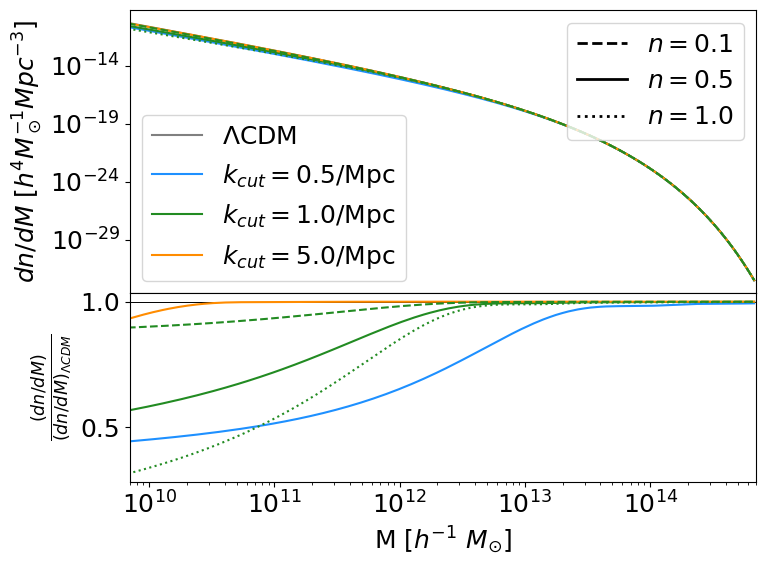

In [9]:
mpl.rcParams['font.size'] = 18

gs = gridspec.GridSpec(2, 1,hspace=0,height_ratios=[3,2])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])
ax.loglog(xM.value, HMF_list[0],label=r'$\Lambda$CDM',color='gray')
ax.loglog(xM.value, HMF_list[1],label=r'$k_{cut}=0.5$/Mpc',color='dodgerblue')
ax.loglog(xM.value, HMF_list[2],label=r'$k_{cut}=1.0$/Mpc',color='forestgreen')
ax.loglog(xM.value, HMF_list[3],label=r'$k_{cut}=5.0$/Mpc',color='darkorange')
ax.loglog(xM.value, HMF_list[4],color='forestgreen',ls='--')
ax.loglog(xM.value, HMF_list[5],color='forestgreen',ls=':')
ax.legend(loc='lower left')
ax.set_ylabel(r'$dn/dM$ [$h^4 M_\odot^{-1} Mpc^{-3}$]')
ax.set_xticks([])
ax.set_xlim(7e9,7e14)

line1, = ax.plot(-xM.value,HMF_list[0],color='k',lw=2,ls='--')
line2, = ax.plot(-xM.value,HMF_list[0],color='k',lw=2,ls='-')
line3, = ax.plot(-xM.value,HMF_list[0],color='k',lw=2,ls=':')
legend1 = ax.legend([line1,line2,line3],
                    [r'$n=0.1$',r'$n=0.5$',r'$n=1.0$'],
                    loc='upper right')
ax.legend(loc='lower left')
plt.gca().add_artist(legend1)

ax=plt.subplot(gs[1,0])
ax.axhline(y=1,color='black',lw=0.7)
ax.semilogx(xM.value,HMF_list[1]/HMF_list[0],color='dodgerblue')
ax.semilogx(xM.value,HMF_list[2]/HMF_list[0],color='forestgreen')
ax.semilogx(xM.value,HMF_list[3]/HMF_list[0],color='darkorange')
ax.semilogx(xM.value,HMF_list[4]/HMF_list[0],color='forestgreen',ls='--')
ax.semilogx(xM.value,HMF_list[5]/HMF_list[0],color='forestgreen',ls=':')
ax.set_xlabel('M [$h^{-1}\ M_{\odot}$]')
ax.set_ylabel(r'$\frac{(dn/dM)}{(dn/dM)_{\Lambda CDM}}$')
ax.set_xlim(7e9,7e14)

fig.tight_layout()
fig.savefig('Figures/HMF_ncdm.pdf',bbox_inches='tight')

In [10]:
M = lim(params('COMAPY5', 'log', 'linear'))
M.update(kmin=M.kmin_field,kmax=10./u.Mpc)
M.update(nonlinear=False, subtract_VID_mean=False, do_ncdm=False)

HMF_list = np.zeros((5, M.nM))

HMF_list[0] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)
xM = M.M.to(M.Msunh)

M.update(cosmo_input_camb={'f_NL':50})
HMF_list[1] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

M.update(cosmo_input_camb={'f_NL':100})
HMF_list[2] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

M.update(cosmo_input_camb={'f_NL':150})
HMF_list[3] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

M.update(cosmo_input_camb={'f_NL':200})
HMF_list[4] = M.dndM.to(M.Msunh**-1 * M.Mpch**-3)

Note: redshifts have been re-sorted (earliest first)


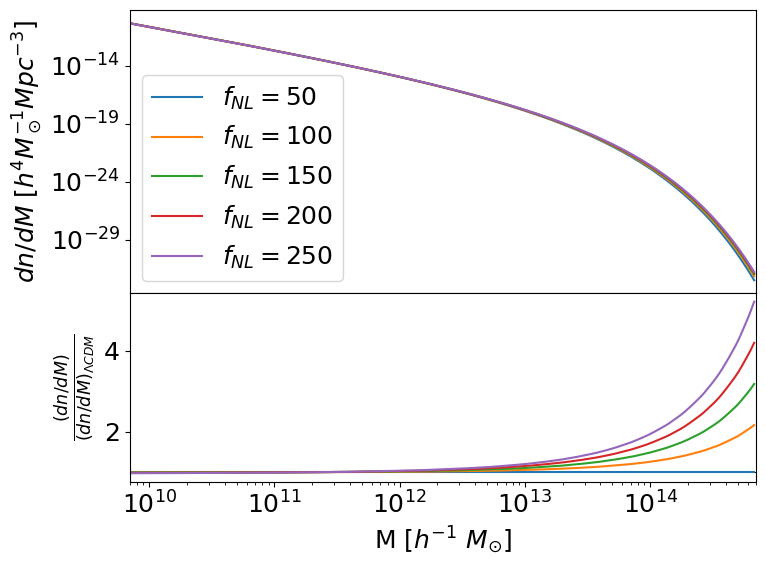

In [11]:
mpl.rcParams['font.size'] = 18

gs = gridspec.GridSpec(2, 1,hspace=0,height_ratios=[3,2])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])
for i in range(len(HMF_list)):
    ax.loglog(xM.value, HMF_list[i],label=r'$f_{NL}=$'+str(50*(i+1)),color=color[i])
ax.legend(loc='lower left')
ax.set_ylabel(r'$dn/dM$ [$h^4 M_\odot^{-1} Mpc^{-3}$]')
ax.set_xticks([])
ax.set_xlim(7e9,7e14)

ax=plt.subplot(gs[1,0])
ax.axhline(y=1,color='black',lw=0.7)
for i in range(len(HMF_list)):
    ax.semilogx(xM.value,HMF_list[i]/HMF_list[0],color=color[i])
ax.set_xlabel('M [$h^{-1}\ M_{\odot}$]')
ax.set_ylabel(r'$\frac{(dn/dM)}{(dn/dM)_{\Lambda CDM}}$')
ax.set_xlim(7e9,7e14)

fig.tight_layout()
fig.savefig('Figures/HMF_fNL.pdf',bbox_inches='tight')

## Power Spectrum Monopole $P_0(k)$

In [37]:
M = lim(params('COMAPY5', 'log', 'linear'))
# M.update(kmin=M.kmin_field,kmax=10./u.Mpc)
M.update(nk=500)
M.update(smooth=False, nonlinear=False, subtract_VID_mean=False, do_ncdm=False)

Pk0_list = np.zeros((6, M.nk))

kh = M.k.to(M.Mpch**-1)
Pk0_list[0] = M.Pk_0.to(M.Mpch**3*u.uK**2)

M.update(do_ncdm=True, kcut=0.5/u.Mpc, slope=0.5)
Pk0_list[1] = M.Pk_0.to(M.Mpch**3*u.uK**2)

M.update(do_ncdm=True, kcut=0.75/u.Mpc, slope=0.5)
Pk0_list[2] = M.Pk_0.to(M.Mpch**3*u.uK**2)

M.update(do_ncdm=True, kcut=1.0/u.Mpc, slope=0.5)
Pk0_list[3] = M.Pk_0.to(M.Mpch**3*u.uK**2)

M.update(do_ncdm=True, kcut=0.75/u.Mpc, slope=0.1)
Pk0_list[4] = M.Pk_0.to(M.Mpch**3*u.uK**2)

M.update(do_ncdm=True, kcut=0.75/u.Mpc, slope=1.0)
Pk0_list[5] = M.Pk_0.to(M.Mpch**3*u.uK**2)

Note: redshifts have been re-sorted (earliest first)


(0.001, 2.6)

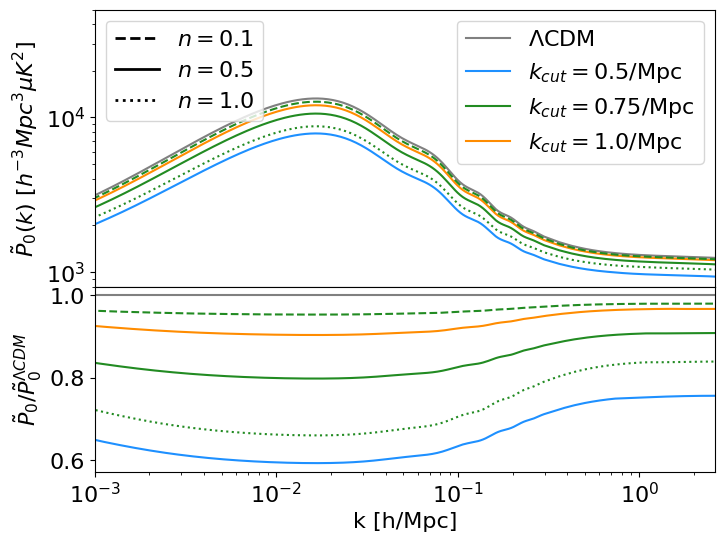

In [48]:
mpl.rcParams['font.size'] = 16

kh = M.k.to(M.Mpch**-1)

gs = gridspec.GridSpec(2, 1,hspace=0, height_ratios=[3,2])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])
ax.loglog(kh.value, Pk0_list[0],label=r'$\Lambda$CDM',color='gray')
ax.loglog(kh.value, Pk0_list[1],label=r'$k_{cut}=0.5$/Mpc',color='dodgerblue')
ax.loglog(kh.value, Pk0_list[2],label=r'$k_{cut}=0.75$/Mpc',color='forestgreen')
ax.loglog(kh.value, Pk0_list[3],label=r'$k_{cut}=1.0$/Mpc',color='darkorange')
ax.loglog(kh.value, Pk0_list[4],color='forestgreen',ls='--')
ax.loglog(kh.value, Pk0_list[5],color='forestgreen',ls=':')
#ax.legend(loc='center left',fontsize=11)
ax.set_ylabel(r'$\tilde{P}_0(k)$ [$h^{-3} Mpc^3 \mu K^2$]')
ax.set_xticks([])
ax.set_xlim(1e-3,2.6)
ax.set_ylim(8e2,5e4)

line1, = ax.plot(-kh.value,Pk0_list[0],color='k',lw=2,ls='--')
line2, = ax.plot(-kh.value,Pk0_list[0],color='k',lw=2,ls='-')
line3, = ax.plot(-kh.value,Pk0_list[0],color='k',lw=2,ls=':')
legend1 = ax.legend([line1,line2,line3],
                    [r'$n=0.1$',r'$n=0.5$',r'$n=1.0$'],
                    loc='upper left')
ax.legend(loc='upper right')
plt.gca().add_artist(legend1)

ax=plt.subplot(gs[1,0])
ax.axhline(y=1,color='black',lw=0.7)
ax.semilogx(kh.value,Pk0_list[0]/Pk0_list[0],color='gray')
ax.semilogx(kh.value,Pk0_list[1]/Pk0_list[0],color='dodgerblue')
ax.semilogx(kh.value,Pk0_list[2]/Pk0_list[0],color='forestgreen')
ax.semilogx(kh.value,Pk0_list[3]/Pk0_list[0],color='darkorange')
ax.semilogx(kh.value,Pk0_list[4]/Pk0_list[0],color='forestgreen',ls='--')
ax.semilogx(kh.value,Pk0_list[5]/Pk0_list[0],color='forestgreen',ls=':')
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel(r'$\tilde{P}_0/\tilde{P}_0^{\Lambda CDM}$')
ax.set_xlim(1e-3,2.6)

## Voxel Intensity Distribution

In [49]:
M = lim(params('COMAPY5', 'log', 'linear'))
# M.update(kmin=M.kmin_field,kmax=10./u.Mpc)
M.update(nk=500)
M.update(smooth=False, nonlinear=False, subtract_VID_mean=False, do_ncdm=False)

PT_list = np.zeros((6, M.nT))

xT = M.T
PT_list[0] = M.PT

M.update(do_ncdm=True, kcut=0.5/u.Mpc, slope=0.5)
PT_list[1] = M.PT

M.update(do_ncdm=True, kcut=0.75/u.Mpc, slope=0.5)
PT_list[2] = M.PT

M.update(do_ncdm=True, kcut=1.0/u.Mpc, slope=0.5)
PT_list[3] = M.PT

M.update(do_ncdm=True, kcut=0.75/u.Mpc, slope=0.1)
PT_list[4] = M.PT

M.update(do_ncdm=True, kcut=0.75/u.Mpc, slope=1.0)
PT_list[5] = M.PT

Note: redshifts have been re-sorted (earliest first)
norm of PT is =  0.9996175544620364
norm of PT is =  0.9997133034848208
norm of PT is =  0.9996745200227014
norm of PT is =  0.999652765202268
norm of PT is =  0.9996309811031379
norm of PT is =  0.9997118610152744


(0.4, 1.1)

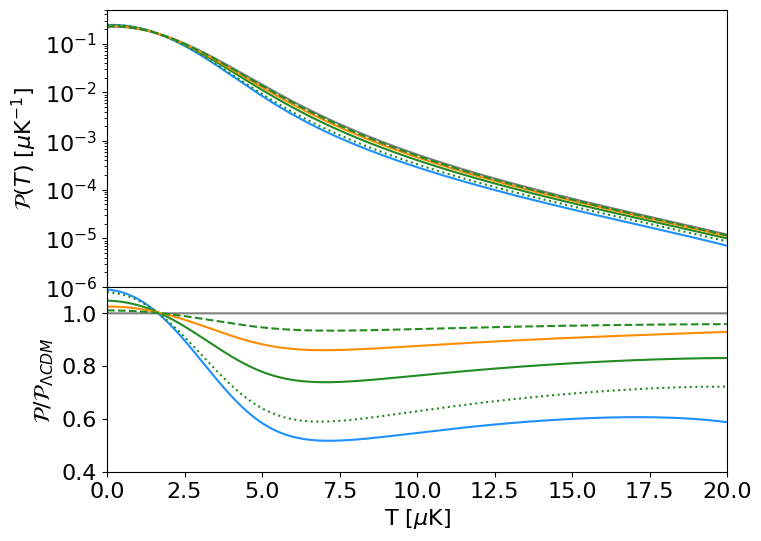

In [51]:
mpl.rcParams['font.size'] = 16

kh = M.k.to(M.Mpch**-1)

gs = gridspec.GridSpec(2, 1,hspace=0, height_ratios=[3,2])
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])
ax.semilogy(xT, PT_list[0],label=r'$\Lambda$CDM',color='gray')
ax.semilogy(xT, PT_list[1],label=r'$k_{cut}=0.5$/Mpc',color='dodgerblue')
ax.semilogy(xT, PT_list[2],label=r'$k_{cut}=0.75$/Mpc',color='forestgreen')
ax.semilogy(xT, PT_list[3],label=r'$k_{cut}=1.0$/Mpc',color='darkorange')
ax.semilogy(xT, PT_list[4],color='forestgreen',ls='--')
ax.semilogy(xT, PT_list[5],color='forestgreen',ls=':')
#ax.legend(loc='center left',fontsize=11)
ax.set_ylabel(r'$\mathcal{P}(T)$ [$\mu$K$^{-1}$]')
ax.set_xticks([])
ax.set_xlim(0,20)
ax.set_ylim(1e-6,5.e-1)

ax=plt.subplot(gs[1,0])
ax.axhline(y=1,color='black',lw=0.7)
ax.plot(xT,PT_list[0]/PT_list[0],color='gray')
ax.plot(xT,PT_list[1]/PT_list[0],color='dodgerblue')
ax.plot(xT,PT_list[2]/PT_list[0],color='forestgreen')
ax.plot(xT,PT_list[3]/PT_list[0],color='darkorange')
ax.plot(xT,PT_list[4]/PT_list[0],color='forestgreen',ls='--')
ax.plot(xT,PT_list[5]/PT_list[0],color='forestgreen',ls=':')
ax.set_xlabel(r'T [$\mu$K]')
ax.set_ylabel(r'$\mathcal{P}/\mathcal{P}_{\Lambda CDM}$')
ax.set_xlim(0,20)
ax.set_ylim(0.4,1.1)

## Fisher Forecast

Example code is shown for LCDM model.

In [12]:
def fiducial(M):
    '''
    Fiducial values of the measured/varied parameters in the analysis.
    Same order in step(),namefile(), and read always that vecparam is used
    '''
    return [M.model_par['A'], M.model_par['B'], M.model_par['logC'], M.model_par['logMs']]

def step():
    '''
    Chosen to be 5% of fiducial values
    '''
    return [0.1425, 0.021, 0.1063, 0.123]
    
# FUNCTIONS FOR POWER SPECTRUM FISHER MATRIX
def namefile(par):
    '''
    Suffix for the names of the file where the varied IM P(k) will be stored
    '''
    LIST = ['A', 'B', 'logC', 'logMs']
    return LIST[par]

def get_Pk_diff(survey,kkind,Tkind):
    '''
    Front function to call and obtain the needed quantities to compute the Fisher Matrix
    
    Computes the fiducial power spectrum, the covariance, and the corresponding derivatives for the Fisher
    '''

    st = step()

    M = lim(params(survey,kkind,Tkind))
    M.update(kmin=M.kmin_field,kmax=10./u.Mpc)

    if survey == 'COMAPY5':
        name = 'output/Pk0_COMAPY5_'
        if kkind == 'log':
            name = 'output/logk_Pk0_COMAPY5_'
    elif survey == 'COMAPXL':
        name = 'output/Pk0_COMAPXL_'
        if kkind == 'log':
            name = 'output/logk_Pk0_COMAPXL_'
    else: raise Exception('Survey must be either COMAPY5 or COMAPXL')
    namefid = name +'fid.txt'

    vecparam = fiducial(M)
    print(vecparam)
    khfid = M.k
    P0 = PN_PK0(M)

    #Get the covariances blocks
    covmat_00 = M.covmat_00

    #Save the file using the LIM's save_in_file function
    #It will be used by the Fisher Matrix Functions
    save_in_file(namefid,[khfid,P0,covmat_00])
        
    #Now compute the derivatives and save them

    for ipar in range(len(st)):
        #namefile
        namedif = name+namefile(ipar)+'.txt'
        print( ipar, namedif)
        if ipar in range(4): #A, B, logC, logMs
            vecparam[ipar] += st[ipar]
            M.update(model_par={'A':vecparam[0], 'B':vecparam[1], 'logC':vecparam[2],'logMs':vecparam[3]})
            P0_plus = PN_PK0(M)
            vecparam[ipar] -= 2*st[ipar]
            M.update(model_par={'A':vecparam[0], 'B':vecparam[1], 'logC':vecparam[2],'logMs':vecparam[3]})
            P0_minus = PN_PK0(M)
            save_in_file(namedif,[khfid,P0_plus,P0_minus])
            vecparam[ipar] += st[ipar]
            M.update(model_par={'A':vecparam[0], 'B':vecparam[1], 'logC':vecparam[2],'logMs':vecparam[3]})  
    return

def getname(survey,kkind):
    '''
    Get the name bits to load files with the fiducial and varied IM P_l(k)
    '''    

    if survey == 'COMAPY5':
        name = 'output/Pk0_COMAPY5_'
        if kkind == 'log':
            name = 'output/logk_Pk0_COMAPY5_'
    elif survey == 'COMAPXL':
        name = 'output/Pk0_COMAPXL_'
        if kkind == 'log':
            name = 'output/logk_Pk0_COMAPXL_'
    else: raise Exception('Survey must be either COMAPY5 or COMAPXL')

    return name

def read_fid(name):
    '''
    Read the files corresponding to the fiducial IM power spectrum and the covariance 
    '''

    #Read quickly one of the Pk files and get the number of elements in k and P_l(k)
    nk = np.loadtxt(name+'fid.txt').shape[0]
    errh = np.zeros((nk,nk))
    fid = np.zeros(nk)

    #Read the file, concatenate the P_l(k), and build the covariance matrix from the blocks
    #Then add them to the corresponding list
    fidfile = np.loadtxt(name+'fid.txt')
    fid = fidfile[:,1]
    errh = np.diag(fidfile[:,2])

    fidP0 = fid
    invcovmat = inv(errh)

    return fidP0,invcovmat

def read_diff(name,st):
    '''
    Read the files where the derivatives are saved and stored them in a list.
        Lists plus/minus include the numerical variations of the IM P_l(k) for +/- step for each parameter
        List analy includes the analytic derivatives for each parameter
    
    If, for instance, one parameter corresponds to an analytic derivative, the entry in plus/minus will be empty,
        and viceversa
        
    Structure of the lists: [z bin[parameter]]
    '''

    #Obtain the number of elements in each P_l(k) by reading one of the files
    nk = np.loadtxt(name+'fid.txt').shape[0]
    Npar = len(st)
    plus = [np.zeros(nk) for x in range(Npar)]
    minus = [np.zeros(nk) for x in range(Npar)] 
    
    #Read the file, concatenate the P_l(k)
    for ipar in range(Npar):
        namein = name+namefile(ipar)+'.txt'
        file = np.loadtxt(namein)
        plus[ipar] = file[:,1]
        minus[ipar] = file[:,2]
                
    return plus,minus

def Fisher_PK(plus_Pkh,minus_Pkh,invcovmath,st):
    '''
    Computes the Fisher matrix for each redshift bin and returns them in a list
    
    It uses the fiducial P_l(k), the plus/minus variations for numerical derivatives,
        the inverse of the covariance matrix and the step (for numerical derivatives)
    '''
    #Number of redshift bins and parameters
    Npar = len(st)

    #Create a list of matrices to store the Fisher
    fisher = np.zeros((Npar,Npar))
    
    #Compute the Fisher matrix via numerical derivatives
    for ipar in range(0,Npar):
        der_i = (plus_Pkh[ipar] - minus_Pkh[ipar])/(2*st[ipar])

        for jpar in range(ipar,Npar):
            der_j = (plus_Pkh[jpar] - minus_Pkh[jpar])/(2.*st[jpar])

            ADD = np.dot(der_i,np.dot(invcovmath,der_j))
            fisher[ipar,jpar] += ADD
        
            if ipar != jpar:
                fisher[jpar,ipar] += ADD

    return fisher

def make_fisher(survey,kkind):
    '''
    Front function to call and compute the Fisher Matrix from the results previously obtained with get_Pk_diff
        and stored in files
    '''
    #Get names and steps
    name = getname(survey,kkind)
    st = step()
    
    #Get the fiducial P_l(k) and variations
    fid_Pkh, fid_invcovmat = read_fid(name)
    plus_Pkh,minus_Pkh = read_diff(name,st)

    #Compute the Fisher. Returns a list whose entries are Fisher matrices for each redshift bin
    Fisher = Fisher_PK(plus_Pkh,minus_Pkh,fid_invcovmat,st)
    
    #Save the list of Fisher matrices in a pickle
    #save_obj(Fisher,'FisherDir/'+name1+name2+hexadecname+'_FISHER')
    save_obj(Fisher,name+'FISHER')
    return Fisher

# FUNCTIONS FOR VID FISHER MATRIX
def get_Bi_diff(survey,kkind,Tkind):
    
    st = step()

    M = lim(params(survey,kkind,Tkind))
    M.update(kmin=M.kmin_field,kmax=10./u.Mpc)

    if survey == 'COMAPY5':
        name = 'output/Bi_COMAPY5_'
        if Tkind == 'log':
            name = 'output/logT_Bi_COMAPY5_'
    elif survey == 'COMAPXL':
        name = 'output/Bi_COMAPXL_'
        if Tkind == 'log':
            name = 'output/logT_Bi_COMAPXL_'
    else: raise Exception('Survey must be either COMAPY5 or COMAPXL')

    namefid = name +'fid.txt'

    #Obtain the fiducial Bi
    vecparam = fiducial(M)
    Ti = M.Ti
    Bi_tot = M.Bi*u.dimensionless_unscaled
    
    #Get the covariances blocks
    #finagle to get sigma in the right form
    sigma2_tot_i = Bi_tot*(1-Bi_tot)/M.Nvox

    save_in_file(namefid,[Ti,Bi_tot,sigma2_tot_i])

    print('Fiducial model done. Moving on to derivative quantities.')

    #Now compute the derivatives and save them
    for ipar in range(len(st)):
        #namefile
        namedif = name+namefile(ipar)+'.txt'
        print( ipar, namedif)
        if ipar in range(4): #A, B, logC, logMs
            vecparam[ipar] += st[ipar]
            M.update(model_par={'A':vecparam[0], 'B':vecparam[1], 'logC':vecparam[2],'logMs':vecparam[3]})
            Bi_tot_plus = M.Bi*u.dimensionless_unscaled
            vecparam[ipar] -= 2*st[ipar]
            M.update(model_par={'A':vecparam[0], 'B':vecparam[1], 'logC':vecparam[2],'logMs':vecparam[3]})
            Bi_tot_minus = M.Bi*u.dimensionless_unscaled
            save_in_file(namedif,[Ti,Bi_tot_plus,Bi_tot_minus])
            vecparam[ipar] += st[ipar]
            M.update(model_par={'A':vecparam[0], 'B':vecparam[1], 'logC':vecparam[2],'logMs':vecparam[3]})     
    return
                       
def getname_vid(survey,Tkind):
    '''
    Get the name bits to load files with the fiducial and varied IM P_l(k)
    '''
    if survey == 'COMAPY5':
        name = 'output/Bi_COMAPY5_'
        if Tkind == 'log':
            name = 'output/logT_Bi_COMAPY5_'
    elif survey == 'COMAPXL':
        name = 'output/Bi_COMAPXL_'
        if Tkind == 'log':
            name = 'output/logT_Bi_COMAPXL_'
    else: raise Exception('Survey must be either COMAPY5 or COMAPXL')

    return name

def read_fid_vid(name):
    '''
    Read the files corresponding to the fiducial Bi and the covariance 
    '''
    fidfile = np.loadtxt(name+'fid.txt')

    fidBi = fidfile[:,1]
    invcovmat = 1/fidfile[:,2]

    return fidBi,invcovmat

def read_diff_vid(name,st):
    '''
    Read the files where the derivatives are saved and stored them in a list.
    '''
    #Read quickly one of the Bi files and get the number of elements in T to shape output arrays
    nT = np.loadtxt(name+'fid.txt').shape[0]
    Npar = len(st)

    plus = [np.zeros(nT) for y in range(Npar)]
    minus = [np.zeros(nT) for y in range(Npar)]
    
    #For each z, read the file, concatenate the P_l(k)
    for ipar in range(Npar):
        namein = name+namefile(ipar)+'.txt'
        file = np.loadtxt(namein)
        plus[ipar] = file[:,1]
        minus[ipar] = file[:,2]

    return plus, minus

def Fisher_VID(plus_Bi,minus_Bi,invcovmat,st):
    '''
    Computes the Fisher matrix and returns it in a list
    
    It uses the fiducial Bi, the plus/minus variations for numerical derivatives, 
        the inverse of the covariance matrix and the step (for numerical derivatives)
    '''
    #Number of redshift bins and parameters
    Npar = len(st)

    #Create a list of matrices to store the Fisher
    fisher = np.zeros((Npar,Npar))
    
    #Compute the Fisher matrix
    for ipar in range(0,Npar):
        der_i = (plus_Bi[ipar] - minus_Bi[ipar])/(2.*st[ipar])
        for jpar in range(ipar,Npar):
            der_j = (plus_Bi[jpar] - minus_Bi[jpar])/(2.*st[jpar])

            #ADD = np.dot(der_i,np.dot(invcovmat,der_j))
            ADD = sum(invcovmat*der_i*der_j)

            fisher[ipar,jpar] += ADD
            if ipar!=jpar:
                fisher[jpar,ipar] += ADD
                    
    return fisher

def make_fisher_vid(survey,Tkind):
    '''
    Front function to call and compute the Fisher Matrix from the results previously obtained with get_Pk_diff
        and stored in files
    '''
    #Get names and steps
    name = getname_vid(survey,Tkind)
    st = step()
    
    #Get the fiducial P_l(k) and variations
    fid_Bi, fid_invcovmat = read_fid_vid(name)
    plus_Bi,minus_Bi = read_diff_vid(name,st)

    #Compute the Fisher. Returns a list whose entries are Fisher matrices for each redshift bin
    Fisher = Fisher_VID(plus_Bi,minus_Bi,fid_invcovmat,st)
    
    #Save the list of Fisher matrices in a pickle
    save_obj(Fisher,name+'FISHER')
    
    return Fisher

# FUNCTIONS FOR JOINT FISHER MATRIX
def calc_Upsilon_fPT(M):
    fT = M.fT_and_edges[0]
    Lsmooth,counts = M.smooth_vox_pop
    dndM = M.dndM
    bM = M.bofM[:,0]
    LofM = M.LofM
    pp = np.zeros((M.nM,len(fT)),dtype='complex128')*u.Msun**-1
    if M.v_of_M is not None and M.smooth_VID:
        for iM in range(M.nM):
            Vprof = M.Vvox*np.sum(counts[iM])
            Lfraction = counts[iM]/np.sum(counts[iM])
            NLsmooth = len(Lsmooth[iM])
            #add the effect of the smoothing
            f_dummy = np.zeros(len(fT),dtype='complex128')
            for jj in range(NLsmooth):
                f_dummy += Lfraction[jj]*M.calc_fP1_pos(fT,LofM[iM]*Lsmooth[iM][jj])
            pp[iM,:] = Vprof*dndM[iM]*(f_dummy-1)
    else:
        Vprof = M.Vvox*np.sum(counts)
        Lfraction = counts/np.sum(counts)
        NLsmooth = len(Lsmooth)
        for iM in range(M.nM):
            #add the effect of the smoothing
            f_dummy = np.zeros(len(fT),dtype='complex128')
            for jj in range(NLsmooth):
                f_dummy += Lfraction[jj]*M.calc_fP1_pos(fT,LofM[iM]*Lsmooth[jj])
            pp[iM,:] = Vprof*dndM[iM]*(f_dummy-1)            
    exp_un = np.trapz(pp,M.M,axis=0)

    if M.do_Jysr:
        sigmaN = (M.sigma_N/np.sqrt(M.tpix*M.Nfeeds)).to(M.Tmean.unit)
    else:
        sigmaN = M.sigma_N
    exp_noise = -fT**2*sigmaN**2/2.  

    fpt_for_ipsilon = np.exp(exp_noise+exp_un)*np.log(np.exp(exp_un))
    return fpt_for_ipsilon

def calc_Upsilon_PT(M):
    fpt_for_ipsilon = calc_Upsilon_fPT(M)
    #Get nodes, weights, positions in Fourier space and intervals for intensities
    nodes,weights = M.leggaus_prep_IFT
    fT, fT_Nind,NlogfT = M.fT_and_edges
    nfT_interval = len(fT_Nind)-1
    T = M.T
    PT_for_ipsilon = np.zeros(M.nT,dtype='complex128')
    dT = 2*M.Tmax_VID/M.nT
    Npi = M.Npi_fT
    #create the nufft plan (type1)
    plan = finufft.Plan(1,(M.nT,),isign=1,eps=1e-6)
    #inverse fourier transform computed piecewise-
    for ifT in range(nfT_interval):
        #prepare for the IFT
        if ifT == nfT_interval-1:
            fTmax = M.fT_max
        else:
            fTmax = fT[fT_Nind[ifT+1]]
        fTvec = dT*fT[fT_Nind[ifT]:fT_Nind[ifT+1]]
        if ifT >= NlogfT-1:
            fTvec -= 2*Npi*np.pi*(ifT-NlogfT+2)
        fPT_toFT = ((fTmax-fT[fT_Nind[ifT]])/2*weights*fpt_for_ipsilon[fT_Nind[ifT]:fT_Nind[ifT+1]])#.astype('complex64')
        #positive fft
        plan.setpts(fTvec)
        PT_for_ipsilon += plan.execute(fPT_toFT)
        #negative fft
        plan.setpts(-fTvec)
        PT_for_ipsilon += plan.execute(fPT_toFT.conj())

    #normalize with the FT convention and give units
    PT_for_ipsilon = PT_for_ipsilon.real/np.pi/2*M.Tmean.unit**-1
    #check normalization
    return PT_for_ipsilon

def calc_Upsilon_i(M):
    PT_for_ipsilon = calc_Upsilon_PT(M)
    Pi = i1d(M.T.value,PT_for_ipsilon,fill_value=0.,bounds_error=False)
    Upsilon_i = np.zeros(M.Nbin_hist)
    for ii in range(M.Nbin_hist):
        Upsilon_i[ii] = quad(Pi,M.Tedge_i[ii].value,M.Tedge_i[ii+1].value)[0]

    return Upsilon_i

def read_files(nameP0, nameBi):

    # power-spectrum
    fidfile_Pk = np.loadtxt(nameP0+'fid.txt')
    fidP0 = fidfile_Pk[:,1]
    covmat00_h6 = np.diag(fidfile_Pk[:,2])

    # VID
    # power-spectrum
    fidfile_Bi = np.loadtxt(nameBi+'fid.txt')
    fidBi = fidfile_Bi[:,1]
    covBiBi = np.diag(fidfile_Bi[:,2])

    return fidP0,covmat00_h6,fidBi,covBiBi

def make_Pk_VID_covmat(survey,kkind, Tkind):    
    M = lim(params(survey,kkind,Tkind))
    M.update(kmin=M.kmin_field,kmax=10./u.Mpc)

    k_cov = M.k 
    Ti_cov = M.Ti

    # load in bispectrum
    if survey == 'COMAPY5': covrootname = 'covmats/cov_COMAP_LCDM.txt'
    elif survey == 'COMAPXL': covrootname = 'covmats/cov_COMAPXL_LCDM.txt'
    else: raise Exception('Survey must be either COMAPY5 or COMAPXL')

    cov_file_unsrt = np.loadtxt(covrootname)
    cov_file_wnan = np.array(sorted(cov_file_unsrt, key=lambda x: x[0]))
    cov_file = cov_file_wnan[~np.isnan(cov_file_wnan[:,3])]

    # interpolate and find values at k's to match Pk's
    k_bispec = cov_file[:,0]
    bispec_int = cov_file[:,1]
    bispec_fn = i1d(k_bispec, bispec_int, bounds_error=False,fill_value='extrapolate')
    bispec = bispec_fn(k_cov)/(4*np.pi*(2*np.pi)**6)*(u.Jy**2*u.Mpc**9/u.sr**2)
    
    #calculate prefactor for covariance
    Upsilon_i = calc_Upsilon_i(M)
    prefactor = (M.Nvox/M.Vfield**2)*Upsilon_i

    prefactor_grid = np.meshgrid(prefactor,bispec)[0]
    bispec_grid = np.meshgrid(prefactor,bispec)[1]

    covBiP0 = prefactor_grid*bispec_grid 
    covP0Bi = np.transpose(covBiP0)

    # make full covariance matrix = xi
    nameP0 = getname(survey,kkind)
    nameBi = getname_vid(survey,Tkind)
    fidP0,covP0P0,fidBi,covBiBi = read_files(nameP0, nameBi)

    xi = np.block([[covP0P0,covP0Bi.value],[covBiP0.value,covBiBi]])

    return k_cov, Ti_cov, xi

def Fisher_XC(plus_P0,minus_P0,plus_Bi,minus_Bi,invcovmat,stP0,stBi):
    '''
    Computes the Fisher matrix and returns it in a list

    '''
    #Number of redshift bins and parameters
    if len(stP0) == len(stBi):
        Npar = len(stP0)
    else: raise Exception('Number of parameters in Pk and VID don\'t match')
        
    #Create a list of matrices to store the Fisher
    fisher = np.zeros((Npar,Npar))
    
    if len(plus_P0) == len(plus_Bi):
        nKT = len(plus_P0)
    else: raise Exception('Number of k/T points in Pk and VID don\'t match')

    #Compute the Fisher matrix
    for ipar in range(0,Npar):
        der_P0_i = (plus_P0[ipar] - minus_P0[ipar])/(2.*stP0[ipar])
        der_Bi_i = (plus_Bi[ipar] - minus_Bi[ipar])/(2.*stBi[ipar])     
        der_i = np.concatenate((der_P0_i,der_Bi_i))
        for jpar in range(ipar,Npar):
            der_Bi_j = (plus_Bi[jpar] - minus_Bi[jpar])/(2.*stBi[jpar])
            der_P0_j = (plus_P0[jpar] - minus_P0[jpar])/(2.*stP0[jpar])
            der_j = np.concatenate((der_P0_j,der_Bi_j))

            ADD = np.dot(der_i,np.dot(invcovmat,der_j))
            
            fisher[ipar,jpar] += ADD
            if ipar!=jpar:
                fisher[jpar,ipar] += ADD
                    
    return fisher

def make_fisher_XC(survey,kkind,Tkind):
    '''
    Front function to call and compute the Fisher Matrix from the results previously obtained with get_Pk_diff
        and stored in files
    '''
    #Get names and steps
    nameP0 = getname(survey,kkind)
    stP0 = step()

    nameBi = getname_vid(survey,Tkind)
    stBi = step()

    plus_P0,minus_P0 = read_diff(nameP0,stP0)
    plus_Bi,minus_Bi = read_diff_vid(nameBi,stBi)

    # Get XC covariance 
    k_cov, Ti_cov, xi = make_Pk_VID_covmat(survey,kkind,Tkind)
    invcovmat = inv(xi)

    if all(idcheck(xi)) == 1.: print('full covariance matrix inverts correctly')
    else: print('problem with inverting full covariance matrix')
    
    #Compute the Fisher. Returns a list whose entries are Fisher matrices for each redshift bin
    Fisher = Fisher_XC(plus_P0,minus_P0,plus_Bi,minus_Bi,invcovmat,stP0,stBi)
    
    # new name 
    if survey == 'COMAPY5': name = 'output/joint_COMAPY5_'
    elif survey == 'COMAPXL': name = 'output/joint_COMAPXL_'
    else: raise Exception('Survey must be either COMAPY5 or COMAPXL')

    #Save the list of Fisher matrices in a pickle
    save_obj(Fisher,name+'FISHER')
    
    return Fisher


Get derivatives of $P_0(k)$ and VID

In [13]:
get_Pk_diff(survey='COMAPY5',kkind='log',Tkind='linear')
get_Bi_diff(survey='COMAPY5',kkind='log',Tkind='linear')

Note: redshifts have been re-sorted (earliest first)
[-2.85, -0.42, 10.63, 12.3]
0 output/logk_Pk0_COMAPY5_A.txt
1 output/logk_Pk0_COMAPY5_B.txt
2 output/logk_Pk0_COMAPY5_logC.txt
3 output/logk_Pk0_COMAPY5_logMs.txt
Note: redshifts have been re-sorted (earliest first)
Note that, for negative intensities, the binning has to be linear
norm of PT is =  0.9991196731447651
Fiducial model done. Moving on to derivative quantities.
0 output/Bi_COMAPY5_A.txt
norm of PT is =  0.9990531509239625
Note that, for negative intensities, the binning has to be linear
norm of PT is =  0.9991720357123813
Note that, for negative intensities, the binning has to be linear
1 output/Bi_COMAPY5_B.txt
norm of PT is =  0.9991464607842442
Note that, for negative intensities, the binning has to be linear
norm of PT is =  0.9990901103272258
Note that, for negative intensities, the binning has to be linear
2 output/Bi_COMAPY5_logC.txt
norm of PT is =  0.9985061096176464
Note that, for negative intensities, the binnin

Construct Fisher and Covariance Matrices

In [14]:
def get_covmat_sigma(fisher):
    covmat = inv(fisher)
    sig = np.diag(covmat)**0.5
    return covmat,sig

In [15]:
float_formatter = "{:.2f}".format
# np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(formatter={'float_kind':None}) # to reset

In [17]:
fisher_Y5_Pk = make_fisher(survey='COMAPY5',kkind='log')
fisher_Y5_VID = make_fisher_vid(survey='COMAPY5',Tkind='linear')
fisher_Y5_XC = make_fisher_XC(survey='COMAPY5',kkind='log',Tkind='linear')
fisher_Y5_noXC = fisher_Y5_Pk+fisher_Y5_VID

covmat_Y5_Pk,sig_Y5_Pk = get_covmat_sigma(fisher_Y5_Pk)
covmat_Y5_VID,sig_Y5_VID = get_covmat_sigma(fisher_Y5_VID)
covmat_Y5_XC,sig_Y5_XC = get_covmat_sigma(fisher_Y5_XC)
covmat_Y5_noXC,sig_Y5_noXC = get_covmat_sigma(fisher_Y5_noXC)

Note: redshifts have been re-sorted (earliest first)
Note that, for negative intensities, the binning has to be linear
full covariance matrix inverts correctly


Plot results

In [18]:
def gaussian(x, mu, sig):
    '''
    Returns an unnormalized Gaussian distribution
    '''
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

M = lim(params('COMAPY5','log','linear'))
M.update(kmin = M.kmin_field, kmax = 10./u.Mpc)

fid = fiducial(M)
A, B, logC, logMs = 0,1,2,3

Note: redshifts have been re-sorted (earliest first)


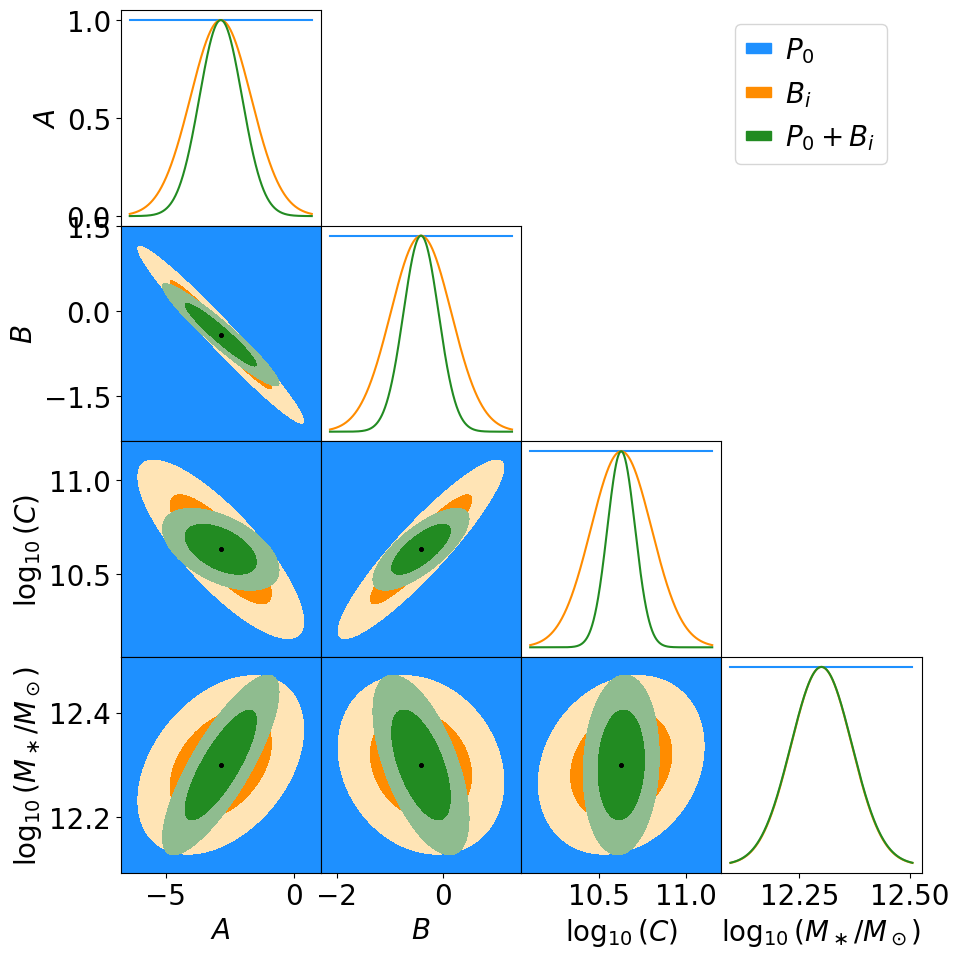

In [32]:
mpl.rcParams['font.size'] = 20

gs = gridspec.GridSpec(4, 4, wspace=0, hspace=0)
fig = plt.figure(figsize=(10,10))

A_lin = np.linspace(fid[A]-3*sig_Y5_VID[A],fid[A]+3*sig_Y5_VID[A],1000)
B_lin = np.linspace(fid[B]-3*sig_Y5_VID[B],fid[B]+3*sig_Y5_VID[B],1000)
logC_lin = np.linspace(fid[logC]-3*sig_Y5_VID[logC],fid[logC]+3*sig_Y5_VID[logC],1000)
logMs_lin = np.linspace(fid[logMs]-3*sig_Y5_VID[logMs],fid[logMs]+3*sig_Y5_VID[logMs],1000)

ax = plt.subplot(gs[0,0])
ax.plot(A_lin, gaussian(A_lin,fid[A],sig_Y5_Pk[A]),color='dodgerblue')
ax.plot(A_lin, gaussian(A_lin,fid[A],sig_Y5_VID[A]),color='darkorange')
ax.plot(A_lin, gaussian(A_lin,fid[A],sig_Y5_XC[A]),color='forestgreen')
ax.set_ylabel(r'$A$')

ax = plt.subplot(gs[1,0])
plot_2d(covmat_Y5_Pk,[A,B],[fid[A],fid[B]],ax,color='dodgerblue',TwoSigma=True)
plot_2d(covmat_Y5_VID,[A,B],[fid[A],fid[B]],ax,color='darkorange',TwoSigma=True)
plot_2d(covmat_Y5_XC,[A,B],[fid[A],fid[B]],ax,color='forestgreen',TwoSigma=True)
ax.set_xlim(A_lin[0], A_lin[-1])
ax.set_ylim(B_lin[0], B_lin[-1])
ax.set_xticks([])
ax.set_ylabel(r'$B$')
ax.set_yticks([-1.5,0.0,1.5])

ax = plt.subplot(gs[2,0])
plot_2d(covmat_Y5_Pk,[A,logC],[fid[A],fid[logC]],ax,color='dodgerblue',TwoSigma=True)
plot_2d(covmat_Y5_VID,[A,logC],[fid[A],fid[logC]],ax,color='darkorange',TwoSigma=True)
plot_2d(covmat_Y5_XC,[A,logC],[fid[A],fid[logC]],ax,color='forestgreen',TwoSigma=True)
ax.set_xlim(A_lin[0], A_lin[-1])
ax.set_ylim(logC_lin[0], logC_lin[-1])
ax.set_xticks([])
ax.set_ylabel(r'$\log_{10}(C)$')

ax = plt.subplot(gs[3,0])
plot_2d(covmat_Y5_Pk,[A,logMs],[fid[A],fid[logMs]],ax,color='dodgerblue',TwoSigma=True)
plot_2d(covmat_Y5_VID,[A,logMs],[fid[A],fid[logMs]],ax,color='darkorange',TwoSigma=True)
plot_2d(covmat_Y5_XC,[A,logMs],[fid[A],fid[logMs]],ax,color='forestgreen',TwoSigma=True)
ax.set_xlim(A_lin[0], A_lin[-1])
ax.set_ylim(logMs_lin[0], logMs_lin[-1])
ax.set_xlabel(r'$A$')
ax.set_ylabel(r'$\log_{10}(M_\ast/M_\odot)$')

########################################################################

ax = plt.subplot(gs[1,1])
ax.plot(B_lin, gaussian(B_lin,fid[B],sig_Y5_Pk[B]),color='dodgerblue')
ax.plot(B_lin, gaussian(B_lin,fid[B],sig_Y5_VID[B]),color='darkorange')
ax.plot(B_lin, gaussian(B_lin,fid[B],sig_Y5_XC[B]),color='forestgreen')
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(gs[2,1])
plot_2d(covmat_Y5_Pk,[B,logC],[fid[B],fid[logC]],ax,color='dodgerblue',TwoSigma=True)
plot_2d(covmat_Y5_VID,[B,logC],[fid[B],fid[logC]],ax,color='darkorange',TwoSigma=True)
plot_2d(covmat_Y5_XC,[B,logC],[fid[B],fid[logC]],ax,color='forestgreen',TwoSigma=True)
ax.set_xlim(B_lin[0], B_lin[-1])
ax.set_ylim(logC_lin[0], logC_lin[-1])
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(gs[3,1])
plot_2d(covmat_Y5_Pk,[B,logMs],[fid[B],fid[logMs]],ax,color='dodgerblue',TwoSigma=True)
plot_2d(covmat_Y5_VID,[B,logMs],[fid[B],fid[logMs]],ax,color='darkorange',TwoSigma=True)
plot_2d(covmat_Y5_XC,[B,logMs],[fid[B],fid[logMs]],ax,color='forestgreen',TwoSigma=True)
ax.set_xlim(B_lin[0], B_lin[-1])
ax.set_ylim(logMs_lin[0], logMs_lin[-1])
ax.set_xlabel(r'$B$')
ax.set_yticks([])

########################################################################

ax = plt.subplot(gs[2,2])
ax.plot(logC_lin, gaussian(logC_lin,fid[logC],sig_Y5_Pk[logC]),color='dodgerblue')
ax.plot(logC_lin, gaussian(logC_lin,fid[logC],sig_Y5_VID[logC]),color='darkorange')
ax.plot(logC_lin, gaussian(logC_lin,fid[logC],sig_Y5_XC[logC]),color='forestgreen')
ax.set_xticks([])
ax.set_yticks([])

ax = plt.subplot(gs[3,2])
plot_2d(covmat_Y5_Pk,[logC,logMs],[fid[logC],fid[logMs]],ax,color='dodgerblue',TwoSigma=True)
plot_2d(covmat_Y5_VID,[logC,logMs],[fid[logC],fid[logMs]],ax,color='darkorange',TwoSigma=True)
plot_2d(covmat_Y5_XC,[logC,logMs],[fid[logC],fid[logMs]],ax,color='forestgreen',TwoSigma=True)
ax.set_xlim(logC_lin[0], logC_lin[-1])
ax.set_ylim(logMs_lin[0], logMs_lin[-1])
ax.set_xlabel(r'$\log_{10}(C)$')
ax.set_yticks([])

########################################################################

ax = plt.subplot(gs[3,3])
ax.plot(logMs_lin, gaussian(logMs_lin,fid[logMs],sig_Y5_Pk[logMs]),color='dodgerblue')
ax.plot(logMs_lin, gaussian(logMs_lin,fid[logMs],sig_Y5_VID[logMs]),color='darkorange')
ax.plot(logMs_lin, gaussian(logMs_lin,fid[logMs],sig_Y5_XC[logMs]),color='forestgreen')
ax.set_xlabel(r'$\log_{10}(M_\ast/M_\odot)$')
ax.set_yticks([])

ax = plt.subplot(gs[0,3])
ax.axis('off')
Pkcolor = mpatches.Patch(color='dodgerblue',alpha=1)
VIDcolor = mpatches.Patch(color='darkorange',alpha=1)
XCcolor = mpatches.Patch(color='forestgreen',alpha=1)
lines = [Pkcolor,VIDcolor,XCcolor]
ax.legend(lines,(r'$P_0$',r'$B_i$',r'$P_0+B_i$'),loc='upper left',handlelength=0.9, handleheight=0.15, handletextpad = 0.5, fontsize = 20 )

fig.tight_layout()
fig.savefig('Figures/LofM_triangle_plot.pdf')

In [33]:
from getdist import plots, MCSamples
from getdist import covmat

# Define parameter names
param_names = ['A', 'B', 'logC', 'logMs']

# Define parameter labels
param_labels = ['A', 'B', 'log_{10}(C)', 'log_{10}(M_\\ast/M_\\odot)']

# Define parameter means
param_means = fiducial(M)

# Create a GetDist MCSamples object
Pk_samples = MCSamples(samples=np.random.multivariate_normal(param_means, covmat_Y5_Pk, size=10000),
                    names=param_names, labels=param_labels)
VID_samples = MCSamples(samples=np.random.multivariate_normal(param_means, covmat_Y5_VID, size=10000),
                    names=param_names, labels=param_labels)
XC_samples = MCSamples(samples=np.random.multivariate_normal(param_means, covmat_Y5_XC, size=10000),
                    names=param_names, labels=param_labels)

Removed no burn in
Removed no burn in
Removed no burn in


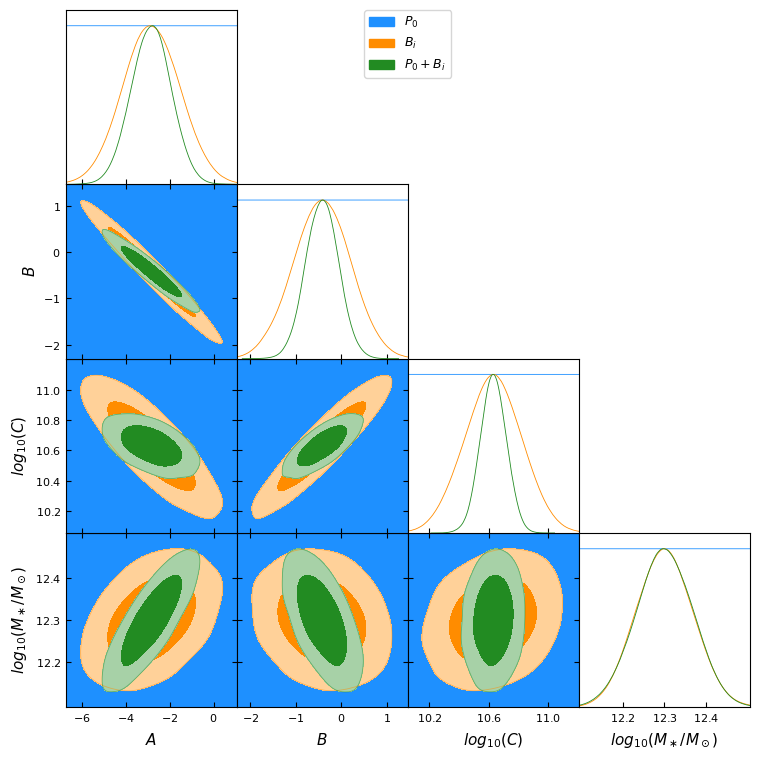

In [34]:
ranges = {'A': (fid[0]-3*sig_Y5_VID[0], fid[0]+3*sig_Y5_VID[0]), 'B': (fid[1]-3*sig_Y5_VID[1], fid[1]+3*sig_Y5_VID[1]), 'logC': (fid[2]-3*sig_Y5_VID[2], fid[2]+3*sig_Y5_VID[2]), 'logMs': (fid[3]-3*sig_Y5_VID[3], fid[3]+3*sig_Y5_VID[3])}

# Create a triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([Pk_samples,VID_samples,XC_samples], filled=True, contour_args={'alpha':1},legend_labels=['$P_0$','$B_i$','$P_0+B_i$'],param_limits=ranges,contour_colors=['dodgerblue','darkorange','forestgreen'],diag1d_kwargs={'lw':2})

g.export('Figures/LofM_triangle_plot_sampled.pdf')  